In [1]:
#@title LICENSE

# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Use Vertex AI Extensions to Generate and Execute code

## Overview

Vertex AI Extensions is a platform for creating and managing extensions that connect large language models to external systems via APIs. These external systems can provide LLMs with real-time data and perform data processing actions on their behalf. You can use pre-built or third-party extensions in Vertex AI Extensions.

Learn more about [Vertex AI Extensions](https://cloud.google.com/vertex-ai/docs/generative-ai/extensions/private/overview).

The Code Interpreter extension ([YAML](gs://vertex-extension-experiment/code_interpreter.yaml)) provides access to a Python interpreter with a sandboxed, secure execution environment that can be used with any model in the Vertex AI Model Garden. This extension can generate and execute code in response to a user query or workflow. It allows the user or LLM agent to perform various tasks such as data analysis and visualization on new or existing data files.

You can use the Code Interpreter extension to:

- generate and execute code;
- perform a wide variety of mathematical calculations;
- sort, filter, select the top results, and otherwise analyze data (including data acquired from other tools and APIs);
- create visualizations, plot charts, draw graphs, shapes, print results, etc.

### Objective

In this tutorial, you'll create and run a pre-built Code Interpreter extension that can generate and execute code. Some example queries are provided that show how to generate Python code and how to work with sample input and output files along with the Code Interpreter extension.

The steps performed include:

- Creating a pre-built extension in your project
- Getting detailed information about the extension
- Setting up various queries to the extension to generate Python code
- Running the extension and working with file inputs, outputs, and results

### Additional information

This tutorial uses the following Google Cloud services and resources:

- Vertex AI Extensions

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.11

### Authenticate your Google Cloud account

You must authenticate to Google Cloud to access the pre-release version of the Python SDK and the Vertex AI Extensions feature.

In [7]:
import sys

if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth
    auth.authenticate_user()

### Installation

This tutorial requires a pre-release version of the Python SDK for Vertex AI. You must be logged in with credentials that are registered for the Vertex AI Extensions Private Preview.

Run the following command to download the library as a wheel from a Cloud Storage bucket:

In [2]:
!gsutil cp gs://vertex_sdk_private_releases/llm_extension/google_cloud_aiplatform-1.39.dev20231219+llm.extension-py2.py3-none-any.whl .

Then, install the following packages required to execute this notebook:

In [3]:
!pip install --force-reinstall --quiet google_cloud_aiplatform-1.39.dev20231219+llm.extension-py2.py3-none-any.whl
!pip install --upgrade --quiet requests==2.31.0 Pillow==10.1.0

Restart the kernel after installing packages:

In [4]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.
1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).
1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).
1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).
1. Your project must also be allowlisted for the Vertex AI Extension Private Preview.
1. This notebook requires that you have the following permissions for your GCP project:
- `roles/aiplatform.user`

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [5]:
PROJECT_ID = "your-project-id"  # @param {type:"string"}

# Set the project ID
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [6]:
REGION = "us-central1"  # @param {type: "string"}

### Import libraries

In [8]:
import base64
import io
import json
import pprint
import requests

import vertexai
from google.cloud.aiplatform.private_preview import llm_extension

from PIL import Image

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [9]:
vertexai.init(project=PROJECT_ID, location=REGION)

## Working with Vertex AI Extensions

### Create the extension

Now you can create the extension itself. The following cell uses the Python SDK to import the extension (thereby creating it) in Vertex AI Extensions.

In [10]:
extension_code_interpreter = llm_extension.Extension.create(
    display_name = "Code Interpreter",
    description = "This extension generates and executes code in the specified language",
    manifest = {
        "name": "code_interpreter_tool",
        "description": "Google Code Interpreter Extension",
        "api_spec": {
            "open_api_gcs_uri": "gs://vertex-extension-experiment/code_interpreter.yaml"
        },
        "auth_config": {
            "google_service_account_config": {},
            "auth_type": "GOOGLE_SERVICE_ACCOUNT_AUTH",
        },
    },
)
extension_code_interpreter

Creating Extension
Create Extension backing LRO: projects/964731510884/locations/us-central1/extensions/1342917113886539776/operations/4391009018210942976
Extension created. Resource name: projects/964731510884/locations/us-central1/extensions/1342917113886539776
To use this Extension in another session:
extension = aiplatform.Extension('projects/964731510884/locations/us-central1/extensions/1342917113886539776')


resource name: projects/964731510884/locations/us-central1/extensions/1342917113886539776

Now that you've imported the Code Interpreter Extension, let's confirm that it's registered:

In [11]:
print("Name:", extension_code_interpreter.gca_resource.name)
print("Display Name:", extension_code_interpreter.display_name)
print("Description:", extension_code_interpreter.gca_resource.description)

Name: projects/964731510884/locations/us-central1/extensions/1342917113886539776
Display Name: Code Interpreter
Description: This extension generates and executes code in the specified language


### Example setup

Here we'll define client options and a helper function to use in the following example sections.

In [12]:
#@title Example code for `parse_output_files(...)` { display-mode: "form" }

# Helper function to parse the output from each example query
def parse_output(response):
    IMAGE_FILE_EXTENSIONS = set(["jpg", "jpeg", "png"])
    print("==============================\n Extension Execution Response: \n==============================\n")
    print("Generated Code: \n===============\n")
    print(response.get("generated_code") + "\n\n")
    if response.get("execution_result"):
        print("Code Execution Result: \n======================\n")
        print('"' + response.get("execution_result") + '"\n\n')
    if response.get("execution_error"):
        print("Code Execution Error: \n=====================\n")
        print('"' + response.get("execution_error") + '"\n\n')
    
    # Sort the output_files so images are displayed before other files such as JSON
    for output_file in sorted(
        response.get("output_files", []),
        key=lambda x: x["name"].split(".")[-1] not in IMAGE_FILE_EXTENSIONS,
    ):
        file_name = output_file.get("name")
        file_contents = base64.b64decode(output_file.get("contents"))
        print("Output Files: \n=======================\n")
        print(f"File Name: {file_name}\n")

        # Render Image
        if file_name.split(".")[-1] in IMAGE_FILE_EXTENSIONS:
            image = Image.open(io.BytesIO(file_contents))
            display(image)
        # Pretty print JSON
        elif file_name.endswith(".json"):
            pprint.pprint(json.loads(file_contents.decode()), compact=False, width=160)
        else:
            print(f"File Contents: {file_contents.decode()}\n")

### Example 1: Prompt with simple instructions

In this example, we'll send a simple prompt with instructions that doesn't depend on any additional data files.

In [13]:
QUERY = "Find the first fibonacci number greater than 999"
response = extension_code_interpreter.execute(
    "generate_and_execute",
    operation_params = {
        "query": QUERY,
    },
)
parse_output(response)

 Extension Execution Response: 

Generated Code: 

```python
def fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a + b
    return a

# Find the first fibonacci number greater than 999
n = 1
while fibonacci(n) <= 999:
    n += 1

print(f"The first fibonacci number greater than 999 is {fibonacci(n)}")
```


Code Execution Result: 

"The first fibonacci number greater than 999 is 1597
"




The output from calling the extension includes the generated Python code and the resulting answer.

### Example 2: Prompt with in-line embedded data

In this example, we'll send a prompt with instructions that includes JSON data in-line with the prompt.

 Extension Execution Response: 

Generated Code: 

```python
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
flower_heights_prices = {
  "Tulip": {"height": 20, "price": 35},
  "Orchid": {"height": 120, "price": 50},
  "Sunflower": {"height": 100, "price": 34},
  "Daisy": {"height": 30, "price": 5},
  "Rose": {"height": 40, "price": 33},
  "Carnation": {"height": 25, "price": 9},
  "Hyacinth": {"height": 20, "price": 11},
  "Iris": {"height": 70, "price": 47},
  "Lily": {"height": 80, "price": 12},
  "Jasmine": {"height": 30, "price": 13},
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(flower_heights_prices).T

# Create a bar chart of the height values
df["height"].plot(kind="bar", color=["red", "green", "blue", "orange", "purple", "yellow", "brown", "pink", "cyan", "magenta"])

# Set the title and labels
plt.title("Flower Heights")
plt.xlabel("Flower")
plt.ylabel("Height (cm)")

# Display the plot
plt.show()
```


Output Files: 

File Name: code_e

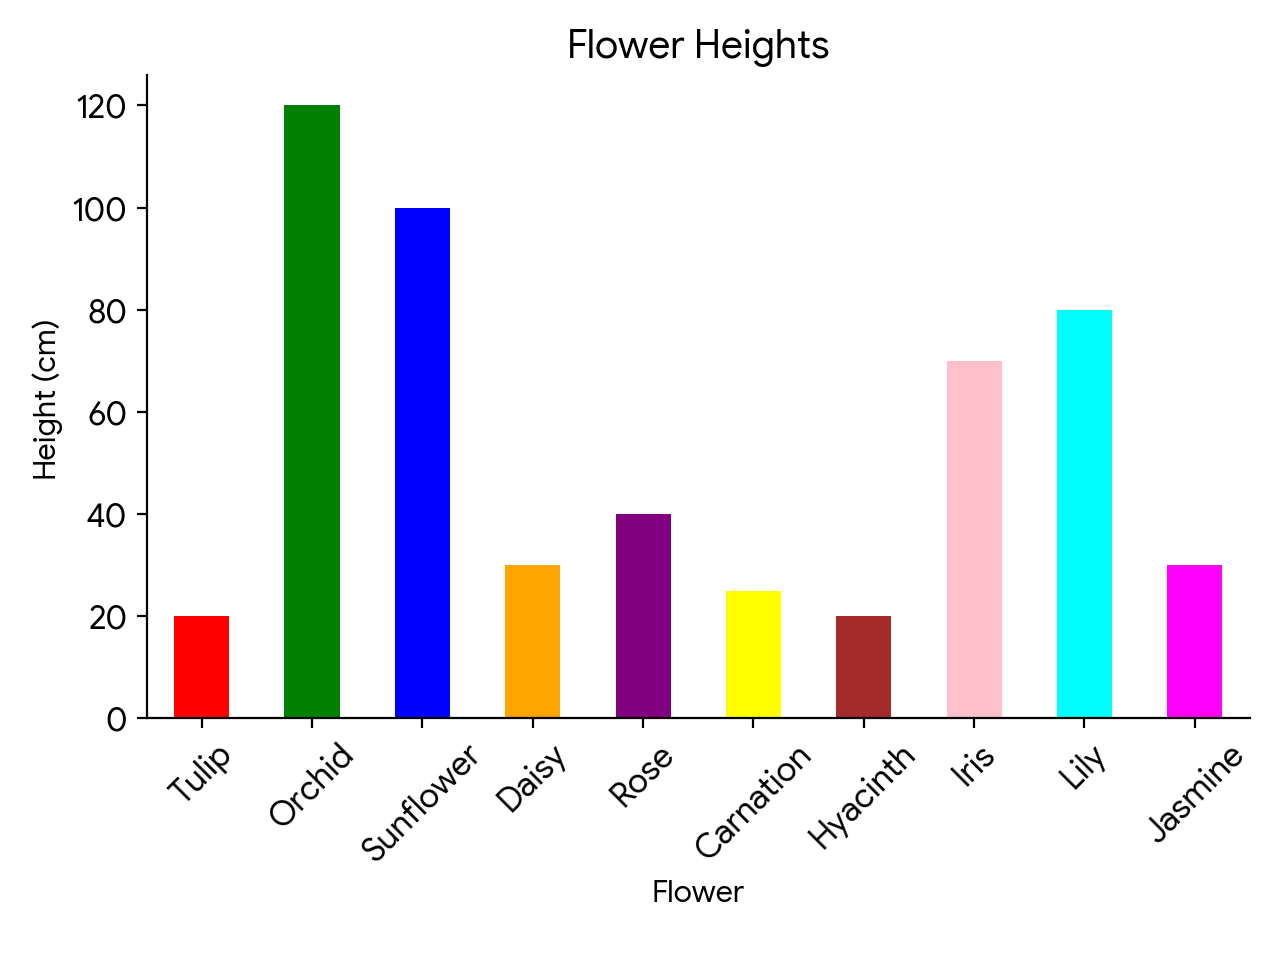

Output Files: 

File Name: bar_chart_1_0_1703014151.3319726.json

{'data': [['Flower', 'height'],
          ['Tulip', 20],
          ['Orchid', 120],
          ['Sunflower', 100],
          ['Daisy', 30],
          ['Rose', 40],
          ['Carnation', 25],
          ['Hyacinth', 20],
          ['Iris', 70],
          ['Lily', 80],
          ['Jasmine', 30]],
 'options': {'colors': ['#ff0000'],
             'hAxis': {'format': '0', 'textStyle': {'fontSize': 12.0}, 'title': 'Height (cm)', 'titleTextStyle': {'fontSize': 11.0}},
             'height': 480,
             'title': 'Flower Heights',
             'vAxis': {'textStyle': {'fontSize': 12.0}, 'title': 'Flower', 'titleTextStyle': {'fontSize': 11.0}},
             'width': 640},
 'plot_type': 'BarChart',
 'title': 'Flower Heights',
 'titleTextStyle': {'fontSize': 14.0}}


In [14]:
QUERY = """
Define the data below in a Python script, then construct a bar chart that
includes only the height values with different colors for the bars:

flower_heights_prices = {
  \"Tulip\": {\"height\": 20, \"price\": 35},
  \"Orchid\": {\"height\": 120, \"price\": 50},
  \"Sunflower\": {\"height\": 100, \"price\": 34},
  \"Daisy\": {\"height\": 30, \"price\": 5},
  \"Rose\": {\"height\": 40, \"price\": 33},
  \"Carnation\": {\"height\": 25, \"price\": 9},
  \"Hyacinth\": {\"height\": 20, \"price\": 11},
  \"Iris\": {\"height\": 70, \"price\": 47},
  \"Lily\": {\"height\": 80, \"price\": 12},
  \"Jasmine\": {\"height\": 30, \"price\": 13},
}

Please include the data in the generated code.
"""

response = extension_code_interpreter.execute(
    operation_id = "generate_and_execute",
    operation_params = {"query": QUERY},
)

parse_output(response)

The output from calling the extension includes the generated Python code, the resulting output, and a plot of the height values from the data.

### Example 3: Prompt using data from an input file

In this example, we'll send a prompt with instructions that uses data from a CSV file that we'll attach to the query. Note that we will make an API call with the `requests` library since the current version of the Python client library does not support file inputs and outputs.

**Set Up Input Files**


> The file contents need to be **base64-encoded** and be passed in with the following structure:


```
[
  {
    "name": "data.csv",
    "contents": "aXRlbTEsaXRlbTI="
  }
]
```

In [15]:
# Download the sample data file and construct the FILES object
!curl -O https://storage.googleapis.com/cloud-samples-data/vertex-ai/extensions/code-interpreter/california-housing-test.csv
filename = "california-housing-test.csv"
with open(filename, "rb") as file:
    encoded_string = base64.b64encode(file.read()).decode()

FILES = [{"name": filename, "contents": encoded_string}]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  294k  100  294k    0     0  1374k      0 --:--:-- --:--:-- --:--:-- 1380k


In [16]:
QUERY = """From the attached CSV file, can you tell me which
house has the maximum median house value? Keep only the first
row. And generate a histogram of median house values."""

 Extension Execution Response: 

Generated Code: 

```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("california-housing-test.csv")

# Find the house with the maximum median house value
max_house_value = df["median_house_value"].max()
max_house_value_row = df[df["median_house_value"] == max_house_value]

# Print the first row of the house with the maximum median house value
print("House with the maximum median house value:")
print(max_house_value_row.head(1))

# Generate a histogram of median house values
plt.hist(df["median_house_value"])
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.title("Histogram of Median House Values")
plt.show()
```


Code Execution Result: 

"House with the maximum median house value:
    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value
42 -118.06     34.15     37.0                1980.0       226.0           697.0    

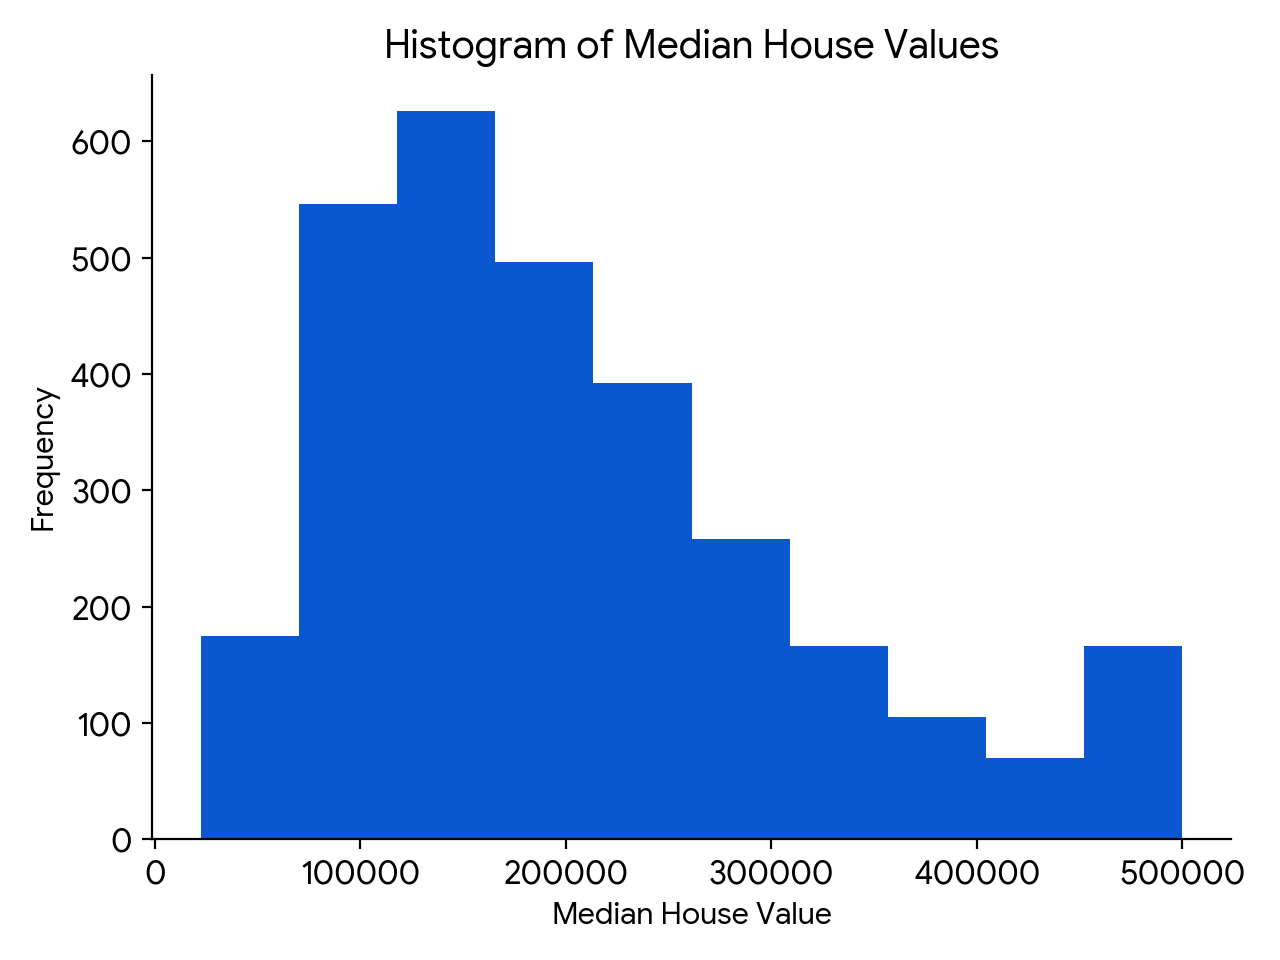

Output Files: 

File Name: bar_chart_1_0_1703014155.5066736.json

{'data': [['Median House Value', ''],
          [46375.05, 175],
          [94125.15, 546],
          [141875.25, 626],
          [189625.34999999998, 496],
          [237375.45, 392],
          [285125.55, 258],
          [332875.65, 166],
          [380625.75, 105],
          [428375.85, 70],
          [476125.94999999995, 166]],
 'options': {'colors': ['#0b57d0'],
             'hAxis': {'textStyle': {'fontSize': 12.0}, 'title': 'Median House Value', 'titleTextStyle': {'fontSize': 11.0}},
             'height': 480,
             'legend': 'none',
             'title': 'Histogram of Median House Values',
             'vAxis': {'format': '0', 'textStyle': {'fontSize': 12.0}, 'title': 'Frequency', 'titleTextStyle': {'fontSize': 11.0}},
             'width': 640},
 'plot_type': 'ColumnChart',
 'title': 'Histogram of Median House Values',
 'titleTextStyle': {'fontSize': 14.0}}


In [17]:
# Execute the extension by specifying the extension name (full path),
# operation ID, and operation parameters (e.g., query and files).
response = extension_code_interpreter.execute(
    operation_id = "generate_and_execute",
    operation_params = {
        "query": QUERY,
        "files": FILES,
    },
)

parse_output(response)

The output from calling the extension includes the generated Python code and the resulting answer.

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources that you created in this tutorial:

In [18]:
# Delete the extension
extension_code_interpreter.delete()

Deleting Extension : projects/964731510884/locations/us-central1/extensions/1342917113886539776
Delete Extension  backing LRO: projects/964731510884/locations/us-central1/operations/4913428224253362176
Extension deleted. . Resource name: projects/964731510884/locations/us-central1/extensions/1342917113886539776
